In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:

df = pd.read_csv("IM.csv", sep=';')
df

,IM,age,man,female,AnamnezIM,Fatness,Diabetes,Hyperlipidemia,ArterialHypertension,FV LV,FP
0,1,70,1,0,0,0,1,0,1,64,0
1,1,79,0,1,0,0,1,0,1,51,0
2,1,57,1,0,0,0,0,1,0,60,0
3,1,59,1,0,0,0,0,0,1,55,0
4,1,80,0,1,0,0,1,0,1,58,0
...,...,...,...,...,...,...,...,...,...,...,...
1094,0,56,1,0,0,0,0,0,1,45,0
1095,0,55,1,0,0,0,0,0,1,52,0
1096,0,68,1,0,0,0,1,0,1,68,0
1097,0,82,1,0,0,0,0,1,1,56,0


e:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


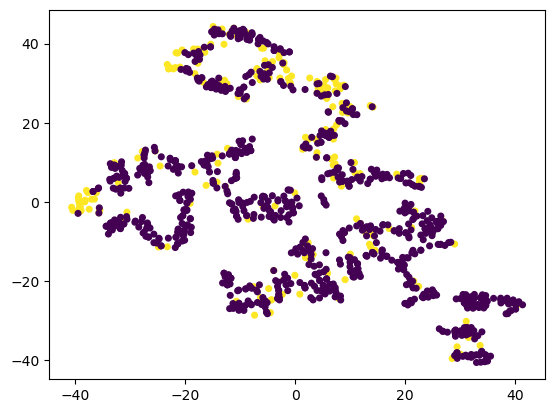

In [4]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate=130, random_state=100)
x_tsne = tsne.fit_transform(df.iloc[:, 1:])
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=df.iloc[:, 0], s=16.5, )

In [5]:
df['age'] = df['age']/100 #нормализация
df['FV LV'] = df['FV LV']/85 #нормализация
df[['FV LV', 'age']]

,FV LV,age
0,0.752941,0.70
1,0.600000,0.79
2,0.705882,0.57
3,0.647059,0.59
4,0.682353,0.80
...,...,...
1094,0.529412,0.56
1095,0.611765,0.55
1096,0.800000,0.68
1097,0.658824,0.82


In [6]:
df

,IM,age,man,female,AnamnezIM,Fatness,Diabetes,Hyperlipidemia,ArterialHypertension,FV LV,FP
0,1,0.70,1,0,0,0,1,0,1,0.752941,0
1,1,0.79,0,1,0,0,1,0,1,0.600000,0
2,1,0.57,1,0,0,0,0,1,0,0.705882,0
3,1,0.59,1,0,0,0,0,0,1,0.647059,0
4,1,0.80,0,1,0,0,1,0,1,0.682353,0
...,...,...,...,...,...,...,...,...,...,...,...
1094,0,0.56,1,0,0,0,0,0,1,0.529412,0
1095,0,0.55,1,0,0,0,0,0,1,0.611765,0
1096,0,0.68,1,0,0,0,1,0,1,0.800000,0
1097,0,0.82,1,0,0,0,0,1,1,0.658824,0


In [7]:
from sklearn.model_selection import train_test_split
#Меня не устраивает что  в train_test_split может в тестовую выборку попасть 0 инфарктов или все 200
#поэтому разделю вручную и соеденю после деления обратно
df_heartattack_x = df[df['IM']==1].iloc[:, 1:]
df_heartattack_y = df[df['IM']==1].iloc[:, 0]
df_no_heartattack_x = df[df['IM']==0].iloc[:, 1:]
df_no_heartattack_y = df[df['IM']==0].iloc[:, 0]

df_heartattack_x_train, df_heartattack_x_test, df_heartattack_y_train, df_heartattack_y_test = train_test_split(df_heartattack_x, df_heartattack_y, test_size=0.2)
df_no_heartattack_x_train, df_no_heartattack_x_test, df_no_heartattack_y_train, df_no_heartattack_y_test = train_test_split(df_no_heartattack_x, df_no_heartattack_y, test_size=0.2)

x_train = pd.concat((df_heartattack_x_train, df_no_heartattack_x_train), axis=0)
y_train = pd.concat((df_heartattack_y_train, df_no_heartattack_y_train), axis=0)
x_test = pd.concat((df_heartattack_x_test, df_no_heartattack_x_test), axis=0)
y_test = pd.concat((df_heartattack_y_test, df_no_heartattack_y_test), axis=0)

Catbost

[[172   8]
 [ 17  23]] 
 roc_auc_score 0.8681944444444444
 rec: 0.575
 prec: 0.7419354838709677
 f1: 0.6478873239436619



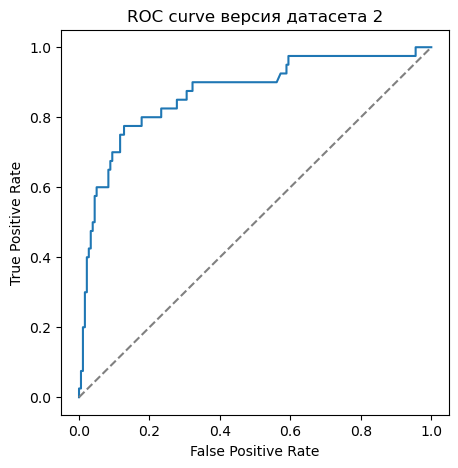

In [8]:
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score, f1_score, precision_score, roc_auc_score, confusion_matrix
model = CatBoostClassifier(n_estimators=40, depth=4, learning_rate=1, loss_function='Logloss', verbose=False)#подобрал вручную
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_proba = model.predict_proba(x_test)
y_proba = y_proba[:, 1]

#результаты по валидационным
print(confusion_matrix(y_test, y_pred), '\n', 
f'roc_auc_score {roc_auc_score(y_test, y_proba)}\n', 
f'rec: {recall_score(y_test, y_pred)}\n',
f'prec: {precision_score(y_test, y_pred)}\n',
f'f1: {f1_score(y_test, y_pred)}\n',
)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
plt.rcParams['figure.figsize'] = 5, 5
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', linestyle='dashed')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve версия датасета 2')
plt.show()

[[712   8]
 [ 52 107]] 
 roc_auc_score 0.9522973445143256
 rec: 0.6729559748427673
 prec: 0.9304347826086956
 f1: 0.7810218978102189



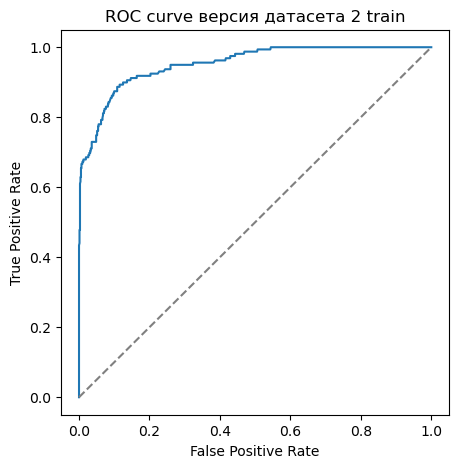

In [9]:
#результаты по тренировочным
y_pred = model.predict(x_train)
y_proba = model.predict_proba(x_train)
y_proba = y_proba[:, 1]
print(confusion_matrix(y_train, y_pred), '\n', 
f'roc_auc_score {roc_auc_score(y_train, y_proba)}\n', 
f'rec: {recall_score(y_train, y_pred)}\n',
f'prec: {precision_score(y_train, y_pred)}\n',
f'f1: {f1_score(y_train, y_pred)}\n',
)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_proba, pos_label=1)
plt.rcParams['figure.figsize'] = 5, 5
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', linestyle='dashed')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve версия датасета 2 train')
plt.show()

In [10]:
from tqdm import tqdm

prediction = model.predict_proba(x_test)
threshold_results = {'threshold':[], 'test_recall_score':[], 'test_f1_score':[], 'test_precision_score':[]}
iters = prediction[:, 1].copy()
iters.sort()
iters = np.unique(iters)

for i in tqdm(iters[:300]):
    predict_mine = []
    for i2 in prediction:
        if i2[1]>i:
            predict_mine.append(1)
        else:
            predict_mine.append(0)
            
    threshold_results['threshold'].append(i)
    threshold_results['test_recall_score'].append(recall_score(y_test, predict_mine))
    threshold_results['test_f1_score'].append(f1_score(y_test, predict_mine))
    threshold_results['test_precision_score'].append(precision_score(y_test, predict_mine))

 97%|█████████▋| 194/201 [00:00<00:00, 270.21it/s]e:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 201/201 [00:00<00:00, 266.39it/s]


Text(0, 0.5, 'метрика')

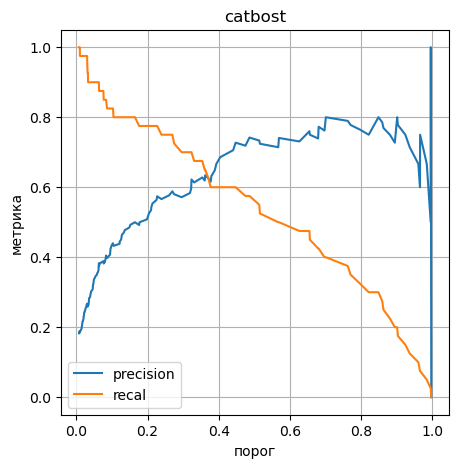

In [11]:
df_threshold_results = pd.DataFrame(threshold_results)

import matplotlib.pyplot as plt
plt.plot(df_threshold_results['threshold'], df_threshold_results['test_precision_score'], label='precision')
plt.plot(df_threshold_results['threshold'], df_threshold_results['test_recall_score'], label='recal')
plt.grid()
plt.legend()
plt.title('catbost')
plt.xlabel('порог')
plt.ylabel('метрика')

KNeighborsClassifier

In [42]:
from sklearn.neighbors import KNeighborsClassifier
results = {'n_neighbors':[], 'roc_auc_score':[],
            'test_recall_score':[], 'test_precision_score':[]}

for i in range(2, 11):
    model = KNeighborsClassifier(n_neighbors=i, algorithm='ball_tree')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]
    results['n_neighbors'].append(i)
    results['roc_auc_score'].append(roc_auc_score(y_test, y_proba))
    results['test_recall_score'].append(recall_score(y_test, y_pred))
    results['test_precision_score'].append(precision_score(y_test, y_pred))

df_results=pd.DataFrame(results)
df_results

e:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
e:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

,n_neighbors,roc_auc_score,test_recall_score,test_precision_score
0,2,0.762500,0.325,0.722222
1,3,0.782639,0.550,0.687500
2,4,0.785903,0.425,0.809524
3,5,0.784306,0.475,0.703704
4,6,0.780139,0.325,0.764706
5,7,0.773194,0.400,0.761905
6,8,0.770139,0.300,0.750000
7,9,0.778264,0.400,0.800000
8,10,0.784514,0.175,0.700000


Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
assumption = round(np.sqrt(x_train.shape[0]))
iter_n_estimators = list(range(100, 900, 50))
iter_max_features = list(range(5, 9))
iter_max_depth = list(range(5, 14))

#все возможные комбинации параметров
a = [iter_n_estimators, iter_max_features, iter_max_depth]
iters = [list(x) for x in np.array(np.meshgrid(*a)).T.reshape(-1,len(a))]#все возможные комбинации параметров

In [49]:
%%time
results = {'iter_n_estimators':[], 'iter_max_features':[], 'iter_max_depth':[], 'train_roc':[], 'test_roc':[],
            'train_recall_score':[], 'train_f1_score':[], 'train_precision_score':[],
            'test_recall_score':[], 'test_f1_score':[], 'test_precision_score':[]}
for i in iters:
    results['iter_n_estimators'].append(i[0])
    results['iter_max_features'].append(i[1])
    results['iter_max_depth'].append(i[2])
    model = RandomForestClassifier(max_depth=i[2], max_features=i[1], n_estimators=i[0])
    model.fit(x_train, y_train)
    test_y_pred = model.predict(x_test)
    train_y_pred = model.predict(x_train)
    test_y_pred_proba = model.predict_proba(x_test)[:, 1]
    train_y_pred_proba = model.predict_proba(x_train)[:, 1]
    results['train_roc'].append(roc_auc_score(y_train, train_y_pred_proba))
    results['test_roc'].append(roc_auc_score(y_test, test_y_pred_proba))
    results['train_recall_score'].append(recall_score(y_train, train_y_pred))
    results['train_f1_score'].append(f1_score(y_train, train_y_pred))
    results['train_precision_score'].append(precision_score(y_train, train_y_pred))
    results['test_recall_score'].append(recall_score(y_test, test_y_pred))
    results['test_f1_score'].append(f1_score(y_test, test_y_pred))
    results['test_precision_score'].append(precision_score(y_test, test_y_pred))

Wall time: 11min 48s


In [50]:
df_results=pd.DataFrame(results)
df_results

,iter_n_estimators,iter_max_features,iter_max_depth,train_roc,test_roc,train_recall_score,train_f1_score,train_precision_score,test_recall_score,test_f1_score,test_precision_score
0,100,5,5,0.887788,0.812361,0.522013,0.683128,0.988095,0.475,0.603175,0.826087
1,100,6,5,0.883499,0.813264,0.540881,0.690763,0.955556,0.475,0.603175,0.826087
2,100,7,5,0.881132,0.812292,0.540881,0.699187,0.988506,0.425,0.548387,0.772727
3,100,8,5,0.882145,0.815764,0.528302,0.688525,0.988235,0.450,0.580645,0.818182
4,150,5,5,0.887736,0.818750,0.534591,0.693878,0.988372,0.475,0.603175,0.826087
...,...,...,...,...,...,...,...,...,...,...,...
571,800,8,13,0.999048,0.868403,0.886792,0.936877,0.992958,0.550,0.586667,0.628571
572,850,5,13,0.998646,0.859236,0.874214,0.929766,0.992857,0.525,0.608696,0.724138
573,850,6,13,0.998899,0.868264,0.874214,0.929766,0.992857,0.550,0.602740,0.666667
574,850,7,13,0.998934,0.866944,0.874214,0.929766,0.992857,0.550,0.594595,0.647059


In [53]:
df_results[df_results['test_roc']==df_results['test_roc'].max()]

,iter_n_estimators,iter_max_features,iter_max_depth,train_roc,test_roc,train_recall_score,train_f1_score,train_precision_score,test_recall_score,test_f1_score,test_precision_score
271,250,8,9,0.97486,0.878472,0.666667,0.796992,0.990654,0.55,0.619718,0.709677
